In [1]:
import pandas as pd, matplotlib.pyplot as plt, re, os
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder



def read_zip_file_as_df(dir_name, zipfile_name, tgt_filename, verbose=True):
    abs_zipfilename = dir_name + zipfile_name
    abs_tgtfilename = dir_name + tgt_filename

    if not os.path.exists(abs_tgtfilename):
        if verbose:  print(f'Trying to extract {abs_zipfilename}')
        with ZipFile(abs_zipfilename, 'r') as zip_ref:
            zip_ref.extractall(dir_name)
    
    df = pd.read_json(abs_tgtfilename, lines=True)
    return df



DIR_NAME = '../Data/'
ZIP_FILE = 'transactions.zip'
FILE_NAME = 'transactions.txt'


df = read_zip_file_as_df(dir_name=DIR_NAME, zipfile_name=ZIP_FILE, tgt_filename=FILE_NAME)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

#### There are no NA values in the dataset that we need to impute/account for

In [2]:
df.isna().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [3]:
df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud             

### Defining the *Levenshtein dissimilarity metric* when there's a cvv-mismatch case

Rather than just binary non-equality, check score of mismatch: a single digit wrong might be just a minor blunder.

In [4]:
import numpy as np
def levenshtein_distance(s1, s2):
    r = len(s1)+1
    c = len(s2)+1
    distance = np.zeros((r,c),dtype = int)

    for i in range(1, r):
        for k in range(1,c):
            distance[i][0] = i
            distance[0][k] = k
            
    for col in range(1, c):
        for row in range(1, r):
            if s1[row-1]==s2[col-1]:
                cost = 0
            else:
                cost = 2
            distance[row][col] = min(
                distance[row-1][col] + 1,         # Cost of deletions
                distance[row][col-1] + 1,         # Cost of insertions
                distance[row-1][col-1] + cost     # Cost of substitutions
            )
    return distance[row][col] / (len(s1)+len(s2))

### Engineer some time-dependent features and one for anomolous card-entry

In [5]:
def add_time_dependent_features(df, col, include_time_fields=False):
    df[col+'Year'] = df[col].dt.year
    df[col+'Month'] = df[col].dt.month
    df[col+'Day'] = df[col].dt.day
    df[col+'DayOfWeek'] = df[col].dt.weekday
    df[col+'Date'] = df[col].dt.date
    if include_time_fields:
        df[col+'Hour'] = df[col].dt.hour
        df[col+'Min'] = df[col].dt.minute
    df = df.drop(col, axis=1)
    return df



df['transactionDt'] = pd.to_datetime(df['transactionDateTime'])
df = add_time_dependent_features(df, 'transactionDt', True)

df['accountOpenDt'] = pd.to_datetime(df['accountOpenDate'])
df = add_time_dependent_features(df, 'accountOpenDt')

df['lastAddressChangeDt'] = pd.to_datetime(df['dateOfLastAddressChange'])
df = add_time_dependent_features(df, 'lastAddressChangeDt')


df = df.astype({'cardCVV':'str', 'enteredCVV':'str'})
# Rather than just binary non-equality, check score of mismatch: a single digit wrong might be just a minor blunder
#df['cvvMismatch'] = df['cardCVV']!=df['enteredCVV']
df['cvvMismatchScore'] = df.apply(lambda x : levenshtein_distance(x['enteredCVV'], x['enteredCVV']), axis=1)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,accountOpenDtDate,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,lastAddressChangeDtDate,cvvMismatchScore
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,3,14,5,2015-03-14,2015,3,14,5,2015-03-14,0.0
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,3,14,5,2015-03-14,2015,3,14,5,2015-03-14,0.0
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,3,14,5,2015-03-14,2015,3,14,5,2015-03-14,0.0
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,3,14,5,2015-03-14,2015,3,14,5,2015-03-14,0.0
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,8,6,3,2015-08-06,2015,8,6,3,2015-08-06,0.0


### Remove the features which have just one categorical value

In [26]:
def drop_unary_columns(df, verbose=False):
    nvalue_counts_df = df.nunique()
    columns_to_drop = nvalue_counts_df.index[nvalue_counts_df.values==1]
    if verbose:  print(f'Columns that will be dropped: {columns_to_drop.values}')
    return df.drop(labels=columns_to_drop, axis=1)


main_df = df.copy(deep=True)
main_df = drop_unary_columns(main_df, verbose=True)
main_df.head()

Columns that will be dropped: ['echoBuffer' 'merchantCity' 'merchantState' 'merchantZip' 'posOnPremises'
 'recurringAuthInd' 'transactionDtYear' 'cvvMismatchScore']


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,accountOpenDtDate,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,lastAddressChangeDtDate
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,2015,3,14,5,2015-03-14,2015,3,14,5,2015-03-14
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,2015,3,14,5,2015-03-14,2015,3,14,5,2015-03-14
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,2015,3,14,5,2015-03-14,2015,3,14,5,2015-03-14
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,2015,3,14,5,2015-03-14,2015,3,14,5,2015-03-14
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015,8,6,3,2015-08-06,2015,8,6,3,2015-08-06


## 4 Transaction types
> `Address-verification` (of course) is done without any payment

> `Purchases` and `Reversals` have a wide range of payment-amounts transacted

> There's also a blank string which we'll impute with `UNK`

In [27]:
def impute_transactionType(main_df):
    main_df['transactionType'] = main_df['transactionType'].replace(r'^\s*$', 'UNK', regex=True)
    return main_df

main_df = impute_transactionType(main_df)
main_df[['transactionAmount','transactionType']].groupby(by=['transactionType'], as_index=False).agg({'transactionAmount':['count','nunique','min','max']})

transactionType transactionAmount                       
                                    count nunique   min      max
0  ADDRESS_VERIFICATION             20169       1  0.00     0.00
1              PURCHASE            745193   66011  0.00  2011.54
2              REVERSAL             20303   14450  0.00  1435.64
3                   UNK               698     685  0.11  1135.64

In [ ]:
import plotly.express as px
fig = px.histogram(
    main_df, 
    x='transactionAmount', 
    color='transactionType', 
    facet_col='transactionType',
    facet_row='isFraud',
    title='Histogram of Transaction-Amt ($) faceted by Transaction-type'
)
fig.update_yaxes(matches=None)
fig.show()

print('Not running this cell while uploading to GIT due to heavy size.')
print('!!! We see Power-law distributions with long right tails. Most transactions have low amounts. !!!')

### Identifying reversal transactions that might've occured after disputes

We'll be looking at pairwise transactions captured for a customer at a specific merchant.

Our final report will contain:

> The first-transaction being `PURCHASE` and the second must be marked as `REVERSAL`

> Both transactions will be for the same customer at the same merchant, and of the same amount.

In [29]:
get_shifted_column = lambda df, colname : df.groupby(by=['customerId'], as_index=False)[[colname]].shift(-1)



def get_reversals_report(main_df):
    REVERSAL_COLS_TO_VIEW = ['customerId','transactionDtDate','transactionAmount','merchantName','transactionType','cardPresent','isFraud']
    COLNAMES_T1_VS_T2 = {
        'transactionAmount' : 'nextTransAmt',
        'transactionDtDate' : 'nextTransDate',
        'merchantName' : 'nextMerchantName',
        'transactionType' : 'nextTransType',
        'isFraud' : 'nextIsFraud'
    }
    reversals_df = main_df[REVERSAL_COLS_TO_VIEW].sort_values(by=['customerId','merchantName','transactionAmount','transactionDtDate'])
    for col, newcol in COLNAMES_T1_VS_T2.items():
        reversals_df[newcol] = get_shifted_column(reversals_df, col)
    reversals_df['durationBetweenTrans'] = reversals_df[COLNAMES_T1_VS_T2['transactionDtDate']] - reversals_df['transactionDtDate']
    reversals_df['durationBetweenTrans'] = (reversals_df['durationBetweenTrans'] / np.timedelta64(1, 'D')).convert_dtypes('int')
    report_reversals_df = reversals_df[
        (reversals_df['merchantName']==reversals_df[COLNAMES_T1_VS_T2['merchantName']])
        &
        (reversals_df['transactionType']=='PURCHASE') & (reversals_df[COLNAMES_T1_VS_T2['transactionType']]=='REVERSAL')
        &
        (reversals_df['transactionAmount']==reversals_df[COLNAMES_T1_VS_T2['transactionAmount']])
    ]
    return report_reversals_df

report_reversals_df = get_reversals_report(main_df)
report_reversals_df

,customerId,transactionDtDate,transactionAmount,merchantName,transactionType,cardPresent,isFraud,nextTransAmt,nextTransDate,nextMerchantName,nextTransType,nextIsFraud,durationBetweenTrans
541963,100088067,2016-11-20,22.32,AMC #79863,PURCHASE,True,False,22.32,2016-11-20,AMC #79863,REVERSAL,False,0
87919,100328049,2016-01-15,43.74,Lyft,PURCHASE,False,False,43.74,2016-01-15,Lyft,REVERSAL,False,0
87935,100328049,2016-03-24,284.97,McDonalds #423357,PURCHASE,True,False,284.97,2016-03-26,McDonalds #423357,REVERSAL,False,2
151496,100737756,2016-05-30,93.67,34th BBQ #436606,PURCHASE,True,False,93.67,2016-06-06,34th BBQ #436606,REVERSAL,False,7
151534,100737756,2016-08-11,501.29,Best Bistro #262998,PURCHASE,True,False,501.29,2016-08-24,Best Bistro #262998,REVERSAL,False,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545580,999258704,2016-09-02,72.93,gap.com,PURCHASE,False,False,72.93,2016-09-02,gap.com,REVERSAL,False,0
670027,999283629,2016-04-09,247.40,Delta Airlines,PURCHASE,False,False,247.40,2016-05-01,Delta Airlines,REVERSAL,False,22
670108,999283629,2016-11-14,150.58,Franks Sandwitch Bar,PURCHASE,True,False,150.58,2016-11-19,Franks Sandwitch Bar,REVERSAL,False,5
670051,999283629,2016-06-01,96.56,Lyft,PURCHASE,False,False,96.56,2016-06-07,Lyft,REVERSAL,False,6


In [ ]:
fig = px.box(
    report_reversals_df, y='durationBetweenTrans', color='isFraud',
    title='Boxplots for duration between Purchase and Reversal transactions'
    )
fig.show()
print('!!! Certainly a Fraudulent transaction is reported and its reversal is performed quicker !!!')

In [ ]:
fig = px.histogram(
    report_reversals_df, 
    x='transactionAmount', 
    color='isFraud',
    facet_col='isFraud',
    title='Very few fraudulent cases reported even if REVERSAL was processed. These few fraudulent cases range mainly from [$45, $300]'
)
fig.update_yaxes(matches=None)
fig.show()

In [32]:
report_reversals_df[(report_reversals_df['customerId']==999283629)]

,customerId,transactionDtDate,transactionAmount,merchantName,transactionType,cardPresent,isFraud,nextTransAmt,nextTransDate,nextMerchantName,nextTransType,nextIsFraud,durationBetweenTrans
670027,999283629,2016-04-09,247.40,Delta Airlines,PURCHASE,False,False,247.40,2016-05-01,Delta Airlines,REVERSAL,False,22
670108,999283629,2016-11-14,150.58,Franks Sandwitch Bar,PURCHASE,True,False,150.58,2016-11-19,Franks Sandwitch Bar,REVERSAL,False,5
670051,999283629,2016-06-01,96.56,Lyft,PURCHASE,False,False,96.56,2016-06-07,Lyft,REVERSAL,False,6
670084,999283629,2016-09-15,407.23,apple.com,PURCHASE,False,False,407.23,2016-10-03,apple.com,REVERSAL,False,18


*Example of a reversal scenario:*
* Customer purchases apple product worth $407.23, realizes doesn't need item or was a mistake, returns immediately.

### Identifying multi-swipe transactions that might've occured accidentally on the same day

For the same candidate-key (`accountNumber`,`merchantName`) if we see 2 or more transactions occured with same amount, then it's likely to be a multi-swipe situation that isn't outright fraud.

In [33]:
# SELECT ACC, MERCHANT WHERE [ACC,MERCHANT] TRANSACTION_TYPE!="REVERSAL" AND SAME TRANSACTIONAMOUNT ON SAME DAY

def get_multiswipe_transactions(main_df):
    transactions_without_reversals = main_df[(main_df['transactionType']!='REVERSAL') & main_df['cardPresent']==True]
    transactions_without_reversals = transactions_without_reversals.groupby(
        by=['customerId','merchantName','transactionDtDate'], as_index=False).agg(
            { 'transactionAmount': ['nunique', 'count'] }
        )
    
    transactions_without_reversals.columns = ['customerId','merchantName','transactionDate','transAmtNunique','transAmtCnt']
    multiswipes_df = transactions_without_reversals[
        (transactions_without_reversals['transAmtNunique']==1) & 
        (transactions_without_reversals['transAmtCnt']>1)
        ].sort_values(by=['customerId','merchantName','transactionDate'])
    
    return multiswipes_df


multiswipes_df = get_multiswipe_transactions(main_df)

In [34]:
view_cols = ['accountNumber','merchantName','transactionAmount','transactionDateTime','cardPresent','isFraud','transactionType']
main_df[
    (main_df['accountNumber']==100737756) & 
    (main_df['merchantName']=='34th BBQ #166379')][view_cols].sort_values(
    by=['transactionDateTime'])

,accountNumber,merchantName,transactionAmount,transactionDateTime,cardPresent,isFraud,transactionType
151447,100737756,34th BBQ #166379,272.00,2016-02-23T14:11:06,True,False,PURCHASE
151517,100737756,34th BBQ #166379,43.25,2016-07-10T14:31:07,True,False,PURCHASE
151518,100737756,34th BBQ #166379,43.25,2016-07-10T14:32:06,True,False,PURCHASE
151575,100737756,34th BBQ #166379,331.72,2016-11-05T17:50:30,True,True,PURCHASE


*Example of a multi-swipe scenario:*
* Customer frequently visits "34th BBQ" restaurant, but on 10th July 2016, 2 transactions occured within a few seconds of each other.
* Neither were reported to be fraudulent.

.

## Moving on to statistical EDA of the dataset

### Describe the numerical columns and plot histograms to view distributions
All numerical-features seem to follow a power-distribution. Ignore the master-data fields like customerId, accountNumber, credit-card details, etc.

In [15]:
main_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardLast4Digits,currentBalance,transactionDtMonth,transactionDtDay,transactionDtDayOfWeek,transactionDtHour,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.00000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,4757.417799,4508.739089,6.648343,15.732804,3.002529,11.511333,29.518682,2013.548618,7.043133,15.917197,3.082027,2014.804087,6.286028,15.476674,2.99443
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,2996.583810,6457.442068,3.436256,8.780564,1.995858,6.921098,17.325778,1.872314,3.378144,8.752827,1.949832,1.881635,3.373176,8.591262,1.96869
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1989.000000,1.000000,1.000000,0.000000,1989.000000,1.000000,1.000000,0.00000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,2178.000000,689.910000,4.000000,8.000000,1.000000,6.000000,15.000000,2013.000000,4.000000,8.000000,1.000000,2014.000000,3.000000,8.000000,1.00000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,4733.000000,2451.760000,7.000000,16.000000,3.000000,12.000000,30.000000,2014.000000,7.000000,16.000000,3.000000,2016.000000,6.000000,15.000000,3.00000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,7338.000000,5291.095000,10.000000,23.000000,5.000000,18.000000,45.000000,2015.000000,10.000000,23.000000,5.000000,2016.000000,9.000000,23.000000,5.00000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,9998.000000,47498.810000,12.000000,31.000000,6.000000,23.000000,59.000000,2015.000000,12.000000,31.000000,6.000000,2016.000000,12.000000,31.000000,6.00000


In [ ]:
for col in ['availableMoney', 'transactionAmount', 'currentBalance']:
    fig = px.histogram(main_df, x=col, facet_col='isFraud', color='isFraud', title=f'{col.capitalize()} for Legitimate vs Fraudulent Transactions. *Facet-scales are different!')
    fig.update_yaxes(matches=None)
    fig.show()

### There are just 12,417 cases of Fraud in our dataset of 786,363

In [45]:
def display_class_imbalance(main_df, label_col='isFraud'):
    count_frauds = main_df[label_col].value_counts()
    print(f'The dataset contains {round(count_frauds[True]/count_frauds[False]*100,2)}% of fraudulent cases.')

display_class_imbalance(main_df)

The dataset contains 1.6% of fraudulent cases.


### Replace boolean-values with binary 0/1 instead
If True --> 1, otherwise 0.

In [46]:
def convert_boolean_to_int(main_df):
    boolean_columns = main_df.select_dtypes(include='bool').columns
    for c in boolean_columns:
        main_df[c] = main_df[c].replace(True, 1).replace(False, 0)
    return main_df

main_df = convert_boolean_to_int(main_df)
main_df[['cardPresent','expirationDateKeyInMatch','isFraud']].value_counts()

cardPresent  expirationDateKeyInMatch  isFraud
0            0                         0          424533
1            0                         0          348383
0            0                         1            8962
1            0                         1            3442
             1                         0            1030
                                       1              13
dtype: int64

# Convert the categorical columns into integer encodings.

> Remember to keep track of the encoding schemes/objects used for test-time.

In [47]:
from sklearn.preprocessing import OrdinalEncoder
# Using ordinal encoder rather than one-hot-encoding since even a 5-valued categorical feature requires 55GB!

get_clean_merchant_name = lambda name: re.sub(r' #.*', '', name).replace('.com', '')
	
	
def encode_categorical_cols(main_df):
	categorical_cols = set(main_df.select_dtypes(include='object').columns)
	categorical_cols -= set(['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange', 'currentExpDate'])
	categorical_cols_encoders = {c : None for c in categorical_cols} # Remember to keep track of the encoder objects for use during test-time
	
	nvalues_categorical_df = main_df[categorical_cols].nunique()
	cols_to_encode = list(nvalues_categorical_df.index[nvalues_categorical_df.values<=20])
	for c in cols_to_encode[::-1]:
		print(f'Ordinal-encoding {c} instead of OHE...')
		categorical_cols_encoders[c] = OrdinalEncoder().fit(main_df[c].values.reshape(-1,1))   # Not using one-hot-encoding since even a 5-valued categorical feature requires 55GB!
		main_df[c] = categorical_cols_encoders[c].transform(main_df[c].values.reshape(-1,1))

	
	# Cleaning the 'Merchant name' column first to reduce 2,400 categories into 200 categories
	c = 'merchantName'
	print(f'Ordinal-encoding {c} instead of OHE...')
	main_df[c] = main_df[c].apply(get_clean_merchant_name)
	categorical_cols_encoders[c] = OrdinalEncoder().fit(main_df[c].values.reshape(-1,1))   # Not using one-hot-encoding since even a 5-valued categorical feature requires 55GB!
	main_df[c] = categorical_cols_encoders[c].transform(main_df[c].values.reshape(-1,1))

	return main_df, categorical_cols_encoders

main_df, categorical_cols_encoders = encode_categorical_cols(main_df)

C:\Users\HP\AppData\Local\Temp\ipykernel_12948\3842379291.py:12: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



Ordinal-encoding transactionType instead of OHE...
Ordinal-encoding posConditionCode instead of OHE...
Ordinal-encoding acqCountry instead of OHE...
Ordinal-encoding merchantCountryCode instead of OHE...
Ordinal-encoding merchantCategoryCode instead of OHE...
Ordinal-encoding posEntryMode instead of OHE...
Ordinal-encoding merchantName instead of OHE...


In [48]:
def drop_irrelevant_columns(main_df, verbose=True):
	cols_to_drop = list(main_df.select_dtypes(exclude=['int64','float64','int32']).columns)
	if verbose:  print(f'Dropping {cols_to_drop}')
	return main_df.drop(cols_to_drop, axis=1)

main_df = drop_irrelevant_columns(main_df)
main_df.head()

Dropping ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'transactionDtDate', 'accountOpenDtDate', 'lastAddressChangeDtDate']


,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,transactionDtHour,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek
0,737265056,737265056,5000,5000.0,98.55,157.0,4.0,4.0,1.0,1.0,...,14,27,2015,3,14,5,2015,3,14,5
1,737265056,737265056,5000,5000.0,74.51,13.0,4.0,4.0,3.0,1.0,...,5,5,2015,3,14,5,2015,3,14,5
2,737265056,737265056,5000,5000.0,7.47,118.0,4.0,4.0,3.0,1.0,...,9,18,2015,3,14,5,2015,3,14,5
3,737265056,737265056,5000,5000.0,7.47,118.0,4.0,4.0,3.0,1.0,...,2,14,2015,3,14,5,2015,3,14,5
4,830329091,830329091,5000,5000.0,71.18,156.0,4.0,4.0,1.0,1.0,...,21,4,2015,8,6,3,2015,8,6,3


In [49]:
from sklearn.preprocessing import MinMaxScaler


def scaledown_numerical_cols(main_df, verbose=True):
    numerical_cols = ['creditLimit', 'availableMoney']
    numerical_col_scalers = {c : None for c in numerical_cols}

    for c in numerical_cols:
        if verbose:  print(f'Using MinMaxScaler() for column `{c}`')
        numerical_col_scalers[c] = MinMaxScaler().fit(main_df[[c]])
        main_df[c] = numerical_col_scalers[c].transform(main_df[[c]])

    return main_df, numerical_col_scalers

main_df, numerical_col_scalers = scaledown_numerical_cols(main_df)

Using MinMaxScaler() for column `creditLimit`
Using MinMaxScaler() for column `availableMoney`


In [ ]:
from sklearn.feature_selection import chi2

subset_cols = set(main_df.columns) - set(['customerId', 'accountNumber', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'isFraud'])
nvalues_categorical_df = main_df[subset_cols].nunique()
categorical_cols_to_view = list(nvalues_categorical_df.index[nvalues_categorical_df.values<=20])
chi2_scores, p_values = chi2(main_df[categorical_cols_to_view], main_df['isFraud'])

chi2_df = pd.DataFrame(categorical_cols_to_view, 1-p_values).reset_index()
chi2_df.columns = ['feature_score (1-p_value)', 'feature']
px.bar(chi2_df, y='feature_score (1-p_value)', x='feature', color='feature_score (1-p_value)', color_continuous_scale='Bluyl', title='Feature importance based on Chi-Squared test')

In [ ]:
from seaborn import heatmap
import numpy as np

plt.rcParams['figure.figsize'] = (15,10)
temp = main_df.nunique()
columns_for_heatmap = set(temp.index[temp.values>20].values) - set(['customerId', 'accountNumber', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'merchantName'])
correlation_matrix = main_df[columns_for_heatmap].corr()
heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, linewidths=0.25, linecolor='grey')
plt.show()

Observable multicollinearity in `accountOpenDtDay` <-> `lastAddressChangeDtDay`. Consider dropping one of these variables.

# Feature-selection based on hypothesis-testing

> Trying out ANOVA-tests for all features since we're dealing with categorical outcome `isFraud`.

In [ ]:
from sklearn.feature_selection import f_classif, SelectKBest

feature_cols = set(main_df.columns) - set(['isFraud', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'accountNumber', 'customerId'])
labels = main_df['isFraud']
features = main_df[feature_cols]

selector = SelectKBest(score_func=f_classif, k='all')
out_features = selector.fit_transform(features, labels)

score_p_values = sorted(selector.pvalues_)

anova_df = pd.DataFrame(selector.get_feature_names_out(), 1-np.array(score_p_values)).reset_index()
#anova_df = pd.DataFrame(feature_cols, 1-selector.pvalues_).reset_index()
anova_df.columns = ['feature_score (1-p_value)', 'feature']
px.bar(anova_df, y='feature_score (1-p_value)', x='feature', color='feature_score (1-p_value)', color_continuous_scale='Bluyl', title='Feature importance based on ANOVA test')

# Training models:

My intuition is- companies lose more loyal customers $\approx 33\%$ due to blocked transactions. An excellent article by Stripe [here](https://stripe.com/guides/primer-on-machine-learning-for-fraud-protection).

On the other hand, fraudulent transactions going unnoticed could lead to potential lawsuits, operational dispute fees, etc.

A subtle line needs to be drawn and my main focus here is to reduce blocked-transactions of legitimate customers: $Type$-$II$ error. 



We can design the Null and Alternative Hypothesis as "A transaction is legitimate until proven otherwise":

> $H_0$ : The transaction is legit.

> $H_1$ : The transaction is fraudulent.

$Type$-$II$ error would be a $False$ $Negative:$ expected $H_0$ but wrongly predicted $H_1$.

### Defining the Feature-set and Label-set to derive the train-test splits

In [ ]:
flip_binary = lambda x: 1 if x==0 else 0
main_df['isFraud'] = main_df['isFraud'].apply(flip_binary)
main_df['isFraud'].value_counts()

1    773946
0     12417
Name: isFraud, dtype: int64

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

feature_cols = set(main_df.columns) - set(['isFraud', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'accountNumber', 'customerId'])
labels = main_df['isFraud']
features = main_df[feature_cols]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, stratify=labels)

C:\Users\HP\AppData\Local\Temp\ipykernel_12948\3814349944.py:6: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



In [64]:
def print_neat_metrics(expected, preds, model_name='Logistic-Regression', show_confusion_matrix=False):
    print(f'Precision = {round(100*precision_score(expected, preds),2)}%.')
    print(f'Recall = {round(100*recall_score(expected, preds),2)}%.')
    print(f'Accuracy = {round(100*accuracy_score(expected, preds),2)}%.')
    print(f'F1 score = {round(100*f1_score(expected, preds),2)}%.')
    
    if show_confusion_matrix:
        tn, fp, fn, tp = confusion_matrix(expected, preds).ravel()
        print(f'Confusion matrix for {model_name} model = \n\tTP={tp}  FN={fn}\n\tFP={fp}  TN={tn}\n')


In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(n_jobs=-1, verbose=1, class_weight=[.1, .9]).fit(x_train, y_train)
preds = logistic_model.predict(x_test)

print_neat_metrics(y_test, preds, 'baseline Logistic-Regression', True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   36.0s finished


Precision = 0.0%.
Recall = 0.0%.
Accuracy = 98.42%.
F1 score = 0.0%.
Confusion matrix for baseline Logistic-Regression model = 
	TP=0  FN=1242
	FP=0  TN=77395



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



### Logistic regression just predicts the majority class. 🤔

### Let's look also at Decision Tree, since Logistic Regression is essentially useless here

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

CLASS_WEIGHTS = { 0: 2, 1: 98 }

decision_tree = DecisionTreeClassifier(class_weight=CLASS_WEIGHTS)
strat_kfold_cv = StratifiedKFold(n_splits=10, shuffle=True)

for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    print(f'Train-stratification: {round(y_train.value_counts()[0]/y_train.count()*100,2)}%, Test-stratification: {round(y_test.value_counts()[0]/y_test.count()*100,2)}%')
    decision_tree.fit(x_train, y_train)
    preds = decision_tree.predict(x_test)
    print_neat_metrics(y_test, preds, 'baseline Decision-Tree', True)

Train-stratification: 98.42%, Test-stratification: 98.42%
Precision = 15.47%.
Recall = 15.78%.
Accuracy = 97.31%.
F1 score = 15.62%.
Confusion matrix for baseline Decision-Tree model = 
	TP=196  FN=1046
	FP=1071  TN=76324

Train-stratification: 98.42%, Test-stratification: 98.42%
Precision = 16.36%.
Recall = 17.07%.
Accuracy = 97.31%.
F1 score = 16.71%.
Confusion matrix for baseline Decision-Tree model = 
	TP=212  FN=1030
	FP=1084  TN=76311

Train-stratification: 98.42%, Test-stratification: 98.42%
Precision = 17.32%.
Recall = 17.39%.
Accuracy = 97.38%.
F1 score = 17.36%.
Confusion matrix for baseline Decision-Tree model = 
	TP=216  FN=1026
	FP=1031  TN=76364

Train-stratification: 98.42%, Test-stratification: 98.42%
Precision = 15.62%.
Recall = 15.63%.
Accuracy = 97.34%.
F1 score = 15.63%.
Confusion matrix for baseline Decision-Tree model = 
	TP=194  FN=1047
	FP=1048  TN=76347

Train-stratification: 98.42%, Test-stratification: 98.42%
Precision = 14.67%.
Recall = 15.31%.
Accuracy = 97

### Atleast now we get a practical prediction rather than just the majority class 🙂
On average baseline has a good $Recall$ ($True Positive Rate$) $\approx 98\%$, and equivalently a good $Precision$ $\approx 98\%$.

### Using a more complex Random-Forest model than baseline Logistic or Decision Tree
Isolation Forest is known to work well with highly-unbalanced sparse datasets (resembling Anomaly detection).

In [66]:
import joblib
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

CLASS_WEIGHTS = { 0: 2, 1: 98 }
param_grid = {
    'n_estimators' : [200],
    'max_depth' : [None],
    'random_state' : [1],
    'min_samples_split' : [2],
    'n_jobs' : [-1],
    'class_weight' : [CLASS_WEIGHTS]
}
random_forest = RandomForestClassifier()

strat_kfold_cv = StratifiedKFold(n_splits=2, shuffle=True)
cv_output = GridSearchCV(random_forest, param_grid=param_grid, cv=strat_kfold_cv, verbose=2).fit(x_train, y_train)

model_path = '../models/random_forest_classifier.pkl'
joblib.dump(cv_output, model_path)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': [{0: 2, 1: 98}], 'max_depth': [None],
                         'min_samples_split': [2], 'n_estimators': [200],
                         'n_jobs': [-1], 'random_state': [1]},
             verbose=1)

In [74]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)
model_path = '../models/random_forest_classifier.pkl'

new_random_forest = joblib.load(model_path)

preds = new_random_forest.predict(x_test)
print_neat_metrics(y_test, preds, 'New Random-Forest', True)

Precision = 100.0%.
Recall = 90.13%.
Accuracy = 99.84%.
F1 score = 94.81%.
Confusion matrix for New Random-Forest model = 
	TP=2238  FN=245
	FP=0  TN=154790



In [ ]:
from sklearn.model_selection import StratifiedKFold

print(f'Best random-forest after grid-search has n_trees: {cv_output.best_estimator_.n_estimators}, and max-depth of trees: {cv_output.best_estimator_.max_depth}')
strat_kfold_cv = StratifiedKFold(n_splits=10, shuffle=True)

for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    preds = cv_output.best_estimator_.predict(x_test)
    print_neat_metrics(y_test, preds, 'Best Random-Forest', True)

Best random-forest after grid-search has n_trees: 200, and max-depth of trees: None
Precision = 100.0%.
Recall = 100.0%.
Accuracy = 100.0%.
F1 score = 100.0%.
Confusion matrix for Best Random-Forest model = 
	TP=1242  FN=0
	FP=0  TN=77395

Precision = 100.0%.
Recall = 100.0%.
Accuracy = 100.0%.
F1 score = 100.0%.
Confusion matrix for Best Random-Forest model = 
	TP=1242  FN=0
	FP=0  TN=77395

Precision = 100.0%.
Recall = 100.0%.
Accuracy = 100.0%.
F1 score = 100.0%.
Confusion matrix for Best Random-Forest model = 
	TP=1242  FN=0
	FP=0  TN=77395

Precision = 100.0%.
Recall = 100.0%.
Accuracy = 100.0%.
F1 score = 100.0%.
Confusion matrix for Best Random-Forest model = 
	TP=1241  FN=0
	FP=0  TN=77395

Precision = 100.0%.
Recall = 100.0%.
Accuracy = 100.0%.
F1 score = 100.0%.
Confusion matrix for Best Random-Forest model = 
	TP=1241  FN=0
	FP=0  TN=77395

Precision = 100.0%.
Recall = 100.0%.
Accuracy = 100.0%.
F1 score = 100.0%.
Confusion matrix for Best Random-Forest model = 
	TP=1241  FN

In [75]:
iso_forest = IsolationForest(n_jobs=-1)

for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    iso_forest.fit(x_train, y_train)
    preds = iso_forest.predict(x_test)
    preds = np.where(preds==-1, 0, preds)
    print_neat_metrics(y_test, preds, 'Isolation-Forest', True)

Precision = 1.54%.
Recall = 78.21%.
Accuracy = 20.78%.
F1 score = 3.02%.
Confusion matrix for Isolation-Forest model = 
	TP=4856  FN=1353
	FP=310141  TN=76832

Precision = 1.52%.
Recall = 78.37%.
Accuracy = 19.59%.
F1 score = 2.99%.
Confusion matrix for Isolation-Forest model = 
	TP=4865  FN=1343
	FP=314832  TN=72141



### Random Forest seems to perform better than the theoretically better Isolation Forest

Random-Forest gives an excellent $Recall$ $\approx 99.9\%$, and great $Precision$ $\approx 98\%$.

> Essentially, it will **very rarely** falsely accuse a legitimate-transaction as being fraudulent (Type-II error).

Seems like a good candidate for final predictions.

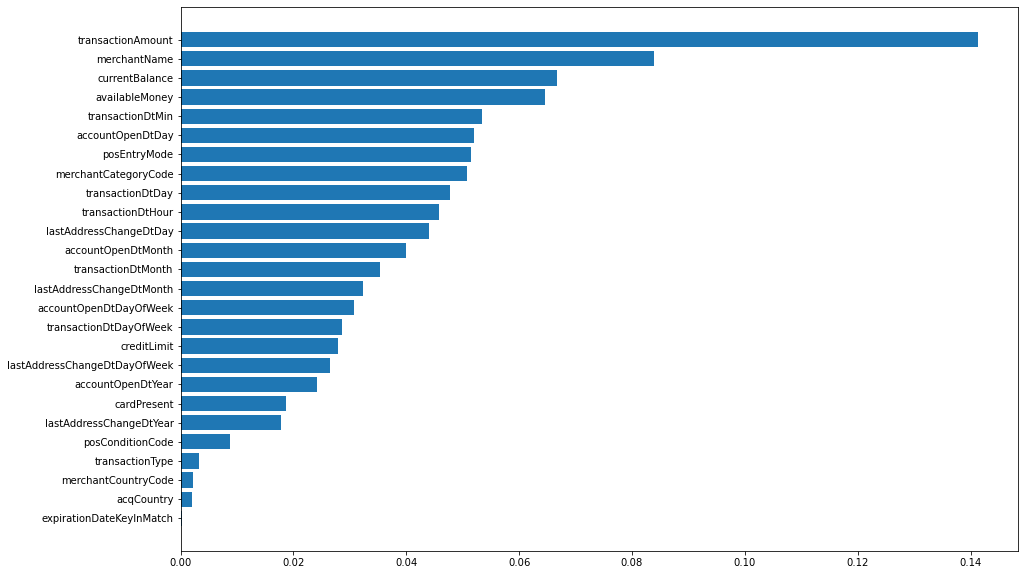

In [76]:
def get_random_forest_feature_importances(gridsearch_model, feature_cols):
    importances = pd.DataFrame(gridsearch_model.best_estimator_.feature_importances_)
    importances.index = feature_cols
    importances = importances.sort_values(by=0)
    return importances

fig, ax = plt.subplots()
importances = get_random_forest_feature_importances(cv_output, features.columns)
ax.barh(importances.index, importances.to_numpy().flatten())
plt.show()